# CL2 - Intro to Convolution Neural Networks in Keras

In this computer lab we'll show you an example of how to define, train, and assess the performance of convolutional neural networks using Keras. For this task, we will use the MNIST dataset, which comprises of 70.000 28x28 grayscale images of handwritten digits (60k for training, 10k for testing).

Our goal is to build a convolutional neural network that takes as input the grayscale image of a handwritten digit, and outputs its corresponding label. As usual, we start by importing the required packages.

In [27]:
# The package for importing the dataset (already provided by Keras)
from keras.datasets import mnist

# Packages for defining the architecture of our model
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D

# One-hot encoding
from keras.utils import np_utils

# Callbacks for training
from keras.callbacks import TensorBoard, EarlyStopping

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline

# Ndarray computations
import numpy as np

# Confusion matrix for assessment step
from sklearn.metrics import confusion_matrix

### 1. Loading and visualizing the data

We can load the MNIST dataset using the function `load_data()`, which already splits it into training and test sets. If this is the first time you're running this cell, you will require internet access to download the dataset.

In [28]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

We can see the range of pixel values by running the following cell:

In [29]:
print('Min:', X_train.min(), '\nMax:', X_train.max())

Min: 0 
Max: 255


And also the shapes of the training set:

In [30]:
X_train.shape

(60000, 28, 28)

In [31]:
y_train.shape

(60000,)

The shape of `X_train` can be interpreted as (samples, width, height). So we can see that the training set is comprised indeed of 60k images, each 28x28. Doing the same for the test set:

In [32]:
X_test.shape

(10000, 28, 28)

In [33]:
y_test.shape

(10000,)

shows us that we have 10k images in the test set, also 28x28.

We can take a look at one of the examples in the training set by simply indexing `X_train` in its first dimension:

In [34]:
X_train[10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118,
        219, 166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254,
        254, 254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

Which shows the 10th data point in the training set as a matrix of numbers. Since we know that each example is actually a grayscale image of a handwritten digit, is more conveninent to display it as an image instead:

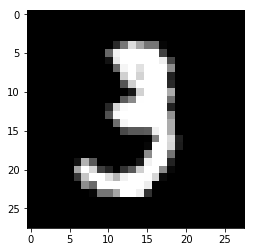

In [35]:
plt.imshow(X_train[10], cmap='gray');

And we can see the corresponding ground truth label by indexing `y_train` with the same index.

In [36]:
y_train[10]

3

### 2. Preprocessing

As we saw previously, the shape of the inputs is:

In [37]:
X_train.shape

(60000, 28, 28)

In [38]:
X_train.shape

(60000, 28, 28)

However, Keras expects input images to have their dimensions in the following format `[samples][width][height][channels]`. Although we have grayscale images (i.e. with only one channel, instead of 3 like RGB images), we should reshape the input to conform to this by adding a new dimension.

In [39]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [40]:
X_train.shape

(60000, 28, 28, 1)

And it's more convenient to work with `ndarray`s of floats, instead of integers.

In [41]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

We also want to normalize the pixel values to range from 0 to 1 (instead of 0 to 255),

In [42]:
X_train = X_train / 255
X_test = X_test / 255

And finally, one hot-encode the output labels.

In [43]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
# one-hot encoding. columns represent the number of possible values for y_test
# that is why we index the column to get the number of classes
num_classes

10

In [44]:
y_train[20]

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

### 3. Training

Now that all the preprocessing steps were taken care of, we are ready to create a tentative model. The following code defines a model with the following layers, from input to output:

- Convolutional layer, 30 filters of size 5x5.
- ReLU
- 2x2 MaxPooling layer
- Fully connected layer with 128 neurons
- ReLU
- Fully connected layer with 10 neurons
- Softmax

In [45]:
def base_model():
    
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Note that the convolutional layer was implemented using a [`Conv2D` layer](https://keras.io/layers/convolutional/#conv2d) and the max pooling layer was implemented using a [`MaxPooling2D` layer](https://keras.io/layers/pooling/#maxpooling2d). Take a look at Keras help page for these layers to obtain more information about them. 

Also, note that in order for Keras to connect the output of the MaxPooling layer (which has shape `(batch, width, heigth, channels)`) to the fully connected layer, it was necessary to first use a [`Flatten` layer](https://keras.io/layers/core/#flatten), which "flattens" its input, squashing all dimensions aside from the batch dimension together. For example, if the input has shape `(32, 28, 28, 3)`, the output will have shape `(32,2352)`.

Now that we defined the architecture, we can train it with the following cell.

In [46]:
# build the model
model = base_model()

# Fit the model
tb = TensorBoard(log_dir='./logs/initial_setting')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=1024, callbacks=[tb])

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 54s 900us/step - loss: 0.5569 - acc: 0.8538 - val_loss: 0.2070 - val_acc: 0.9420
Epoch 2/15
60000/60000 [==============================] - 54s 894us/step - loss: 0.1663 - acc: 0.9520 - val_loss: 0.1179 - val_acc: 0.9650
Epoch 3/15
60000/60000 [==============================] - 54s 901us/step - loss: 0.1030 - acc: 0.9711 - val_loss: 0.0787 - val_acc: 0.9767
Epoch 4/15
60000/60000 [==============================] - 54s 908us/step - loss: 0.0772 - acc: 0.9787 - val_loss: 0.0699 - val_acc: 0.9791
Epoch 5/15
60000/60000 [==============================] - 55s 913us/step - loss: 0.0620 - acc: 0.9823 - val_loss: 0.0562 - val_acc: 0.9827
Epoch 6/15
60000/60000 [==============================] - 55s 913us/step - loss: 0.0520 - acc: 0.9854 - val_loss: 0.0507 - val_acc: 0.9834
Epoch 7/15
60000/60000 [==============================] - 55s 916us/step - loss: 0.0443 - acc: 0.9874 - val_loss: 0.

Try different architectures.

In [ ]:
def more_layers_model():
    
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def more_filters_model():
    
    model = Sequential()
    model.add(Conv2D(100, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def more_neurons_model():
    
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def bnorm_model():
    
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Train all of them and compare the results using [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard). To see the tensorboard results, open a terminal in the directory where this notebook is, and type `tensorboard --logdir=logs`. This will start the TensorBoard server and show you its address. Follow that address to access its web interface.

Note: if you're running a notebook from the cloud, follow the instructions inside the `Instructions` folder about how to use TensorBoard instead. 

In [ ]:
model_names = ['more_layers_model', 'more_filters_model', 'more_neurons_model', 'bnorm_model']

for name in model_names:
    print('Training model:',name)
    model = globals()[name]()
    tb = TensorBoard(log_dir='./logs/'+name)
    model.fit(X_train,
              y_train, 
              validation_data=(X_test, y_test),
              epochs=15, 
              batch_size=1024, 
              callbacks=[tb],
              verbose=0)
    print('Done!')

Choose the best one and train longer. Here we also use [early stopping](https://en.wikipedia.org/wiki/Early_stopping#Validation-based_early_stopping).

In [ ]:
model = base_model()

# Set callbacks
tb = TensorBoard(log_dir='./logs/final_model')
estop = EarlyStopping(monitor='val_acc', patience=5)

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=1024, callbacks=[tb, estop])

### 4. Assessment

Once we found our best model, we can evaluate its performance on the test set. In our case, we would like to compute its accuracy:

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
temp = model.predict(X_test)
y_pred = np.argmax(temp, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_matrix(y_true, y_pred)

What can you conclude from these? Which classes are the easiest to misclassify? Was that expected?